In [43]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from packaging import version
import sklearn

In [44]:
# Set display options
pd.set_option('display.max_columns', None)

In [45]:
# Load dataset
data_path = r"\house-prices-advanced-regression-techniques"
for dirname, _, filenames in os.walk(data_path):
    for filename in filenames:
        print(filename)

data_description.txt
sample_submission.csv
test.csv
train.csv


In [46]:
train_file_path = os.path.join(data_path, 'train.csv')
dataset_df = pd.read_csv(train_file_path)
print("Original train dataset shape:", dataset_df.shape)

Original train dataset shape: (1460, 81)


In [47]:
# Drop non-informative ID column
dataset_df = dataset_df.drop('Id', axis=1)

In [48]:
# Data info
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [49]:
# Describe target column
print(dataset_df['SalePrice'].describe())

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


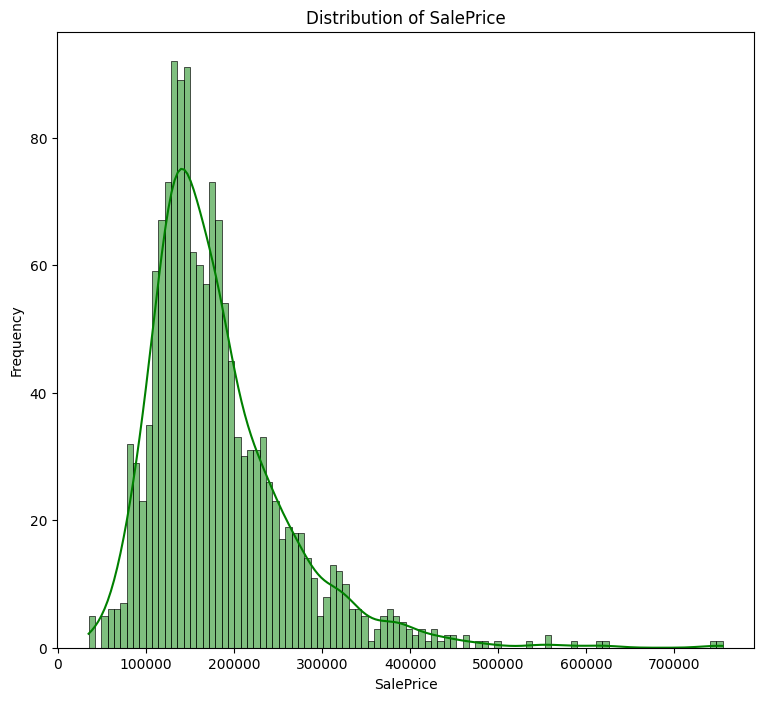

In [50]:
# Visualize the distribution of target variable
plt.figure(figsize=(9, 8))
sns.histplot(dataset_df['SalePrice'], color='g', bins=100, kde=True)
plt.title("Distribution of SalePrice")
plt.xlabel("SalePrice")
plt.ylabel("Frequency")
plt.show()

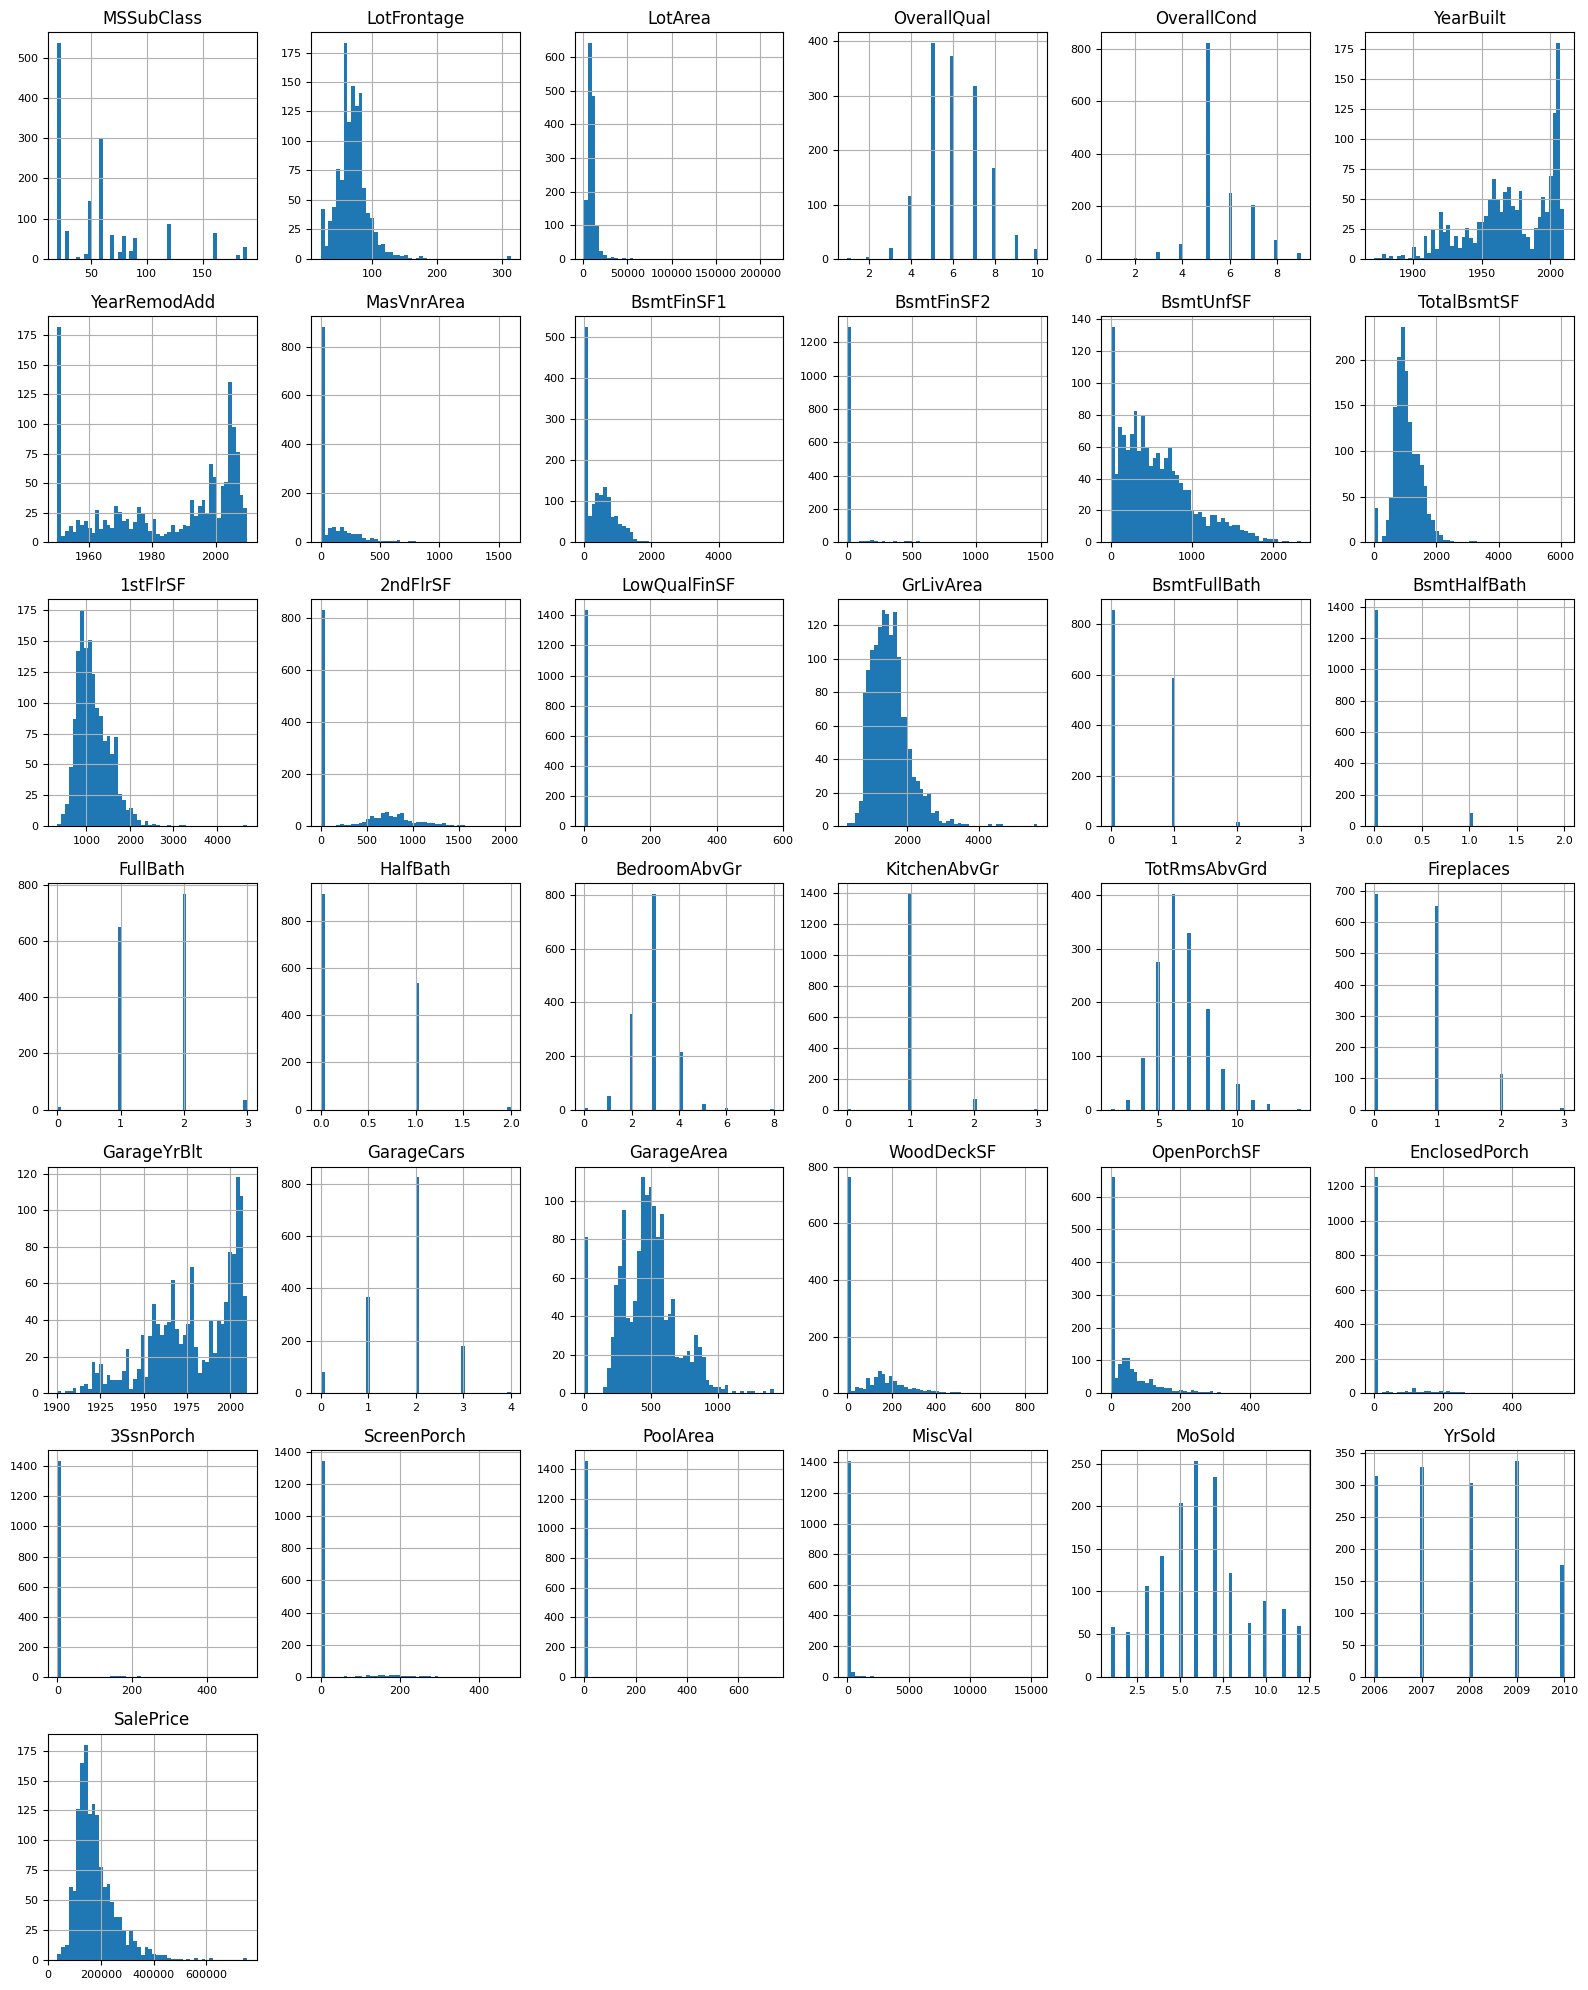

In [51]:
# Plot histograms for all numerical features
df_num = dataset_df.select_dtypes(include=['float64', 'int64'])
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)
plt.tight_layout()
plt.show()

In [52]:
# Split dataset manually
def split_dataset(dataset, test_ratio=0.30):
    test_indices = np.random.rand(len(dataset)) < test_ratio
    return dataset[~test_indices], dataset[test_indices]

train_ds_pd, valid_ds_pd = split_dataset(dataset_df)
print(f"{len(train_ds_pd)} training examples, {len(valid_ds_pd)} validation examples")

1039 training examples, 421 validation examples


In [53]:
# Separate features and target
X_train = train_ds_pd.drop('SalePrice', axis=1)
y_train = train_ds_pd['SalePrice']
X_valid = valid_ds_pd.drop('SalePrice', axis=1)
y_valid = valid_ds_pd['SalePrice']

In [54]:
# Identify feature types
numerical_cols = [col for col in X_train.columns if X_train[col].dtype in ['int64', 'float64']]
categorical_cols = [col for col in X_train.columns if X_train[col].dtype == "object"]

print("Sample numerical columns:", numerical_cols[:5])
print("Sample categorical columns:", categorical_cols[:5])

Sample numerical columns: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond']
Sample categorical columns: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour']


In [55]:
if version.parse(sklearn.__version__) >= version.parse("1.2"):
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
else:
    encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [56]:
# Preprocessing pipelines
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])


In [57]:
# Combine transformers into a ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

In [58]:
# Fit and transform the data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_valid_preprocessed = preprocessor.transform(X_valid)

print("Preprocessed training data shape:", X_train_preprocessed.shape)
print("Preprocessed validation data shape:", X_valid_preprocessed.shape)

Preprocessed training data shape: (1039, 280)
Preprocessed validation data shape: (421, 280)


In [59]:
# Linear Regression Training
model = LinearRegression()
model.fit(X_train_preprocessed, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [60]:
# Prediction
preds = model.predict(X_valid_preprocessed)

In [61]:
# Evaluation
rmse = np.sqrt(mean_squared_error(y_valid, preds))
print(f"Validation RMSE: {rmse:.2f}")

Validation RMSE: 26508.88
